In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm

import torch
import transformers
from transformers import BertModel, BertTokenizer
from transformers import AutoTokenizer, AutoModel#ForMaskedLM

esm_model = transformers.models.esm.EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_tokenizer = transformers.models.esm.EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D", do_lower_case=False)

prot_tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
prot_model = BertModel.from_pretrained("Rostlab/prot_bert")

smiles_tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-5M-MLM")
smiles_model = AutoModel.from_pretrained("DeepChem/ChemBERTa-5M-MLM")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-5M-MLM and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You load some tsv-file available in Binding database. In the next cell, you work with the version `BindingDB_BindingDB_Articles_202508_tsv.zip ( 16.82 MB, updated 2025-07-28 ) md5`, which you find in the website https://www.bindingdb.org/rwd/bind/chemsearch/marvin/Download.jsp

Next, we want to model the strength of the binding between a aminoacid sequence with a ligand. For that purpose, there is column in the tsv-file which corresponds to the dissociation constant of the pair ligand-aminoacid sequence. The lower the Kd, the stronger the bind between the interacting molecules. We transform the Kd to pKd values, which is the most common manner to talk about this constant in chemistry. pKd is simply defined as $-log Kd$. The Kd values are reported in nmol/L.

In [2]:
df = pd.read_csv('./BindingDB_All_202508_tsv/BindingDB_BindingDB_Articles.tsv', 
                 sep='\t', quoting=csv.QUOTE_NONE, on_bad_lines='warn')

df = df[['Ligand SMILES', 'BindingDB Target Chain Sequence', 'Kd (nM)']].dropna()

def convert_kd(cleaned):
    try:

        if cleaned:  
            return -np.log10(float(cleaned) * 10**-9)
        return float('nan') 
    except (ValueError, TypeError):
        return float('nan') 

df['Kd (nM)'] = df['Kd (nM)'].apply(convert_kd)

C:\Users\igofo\AppData\Local\Temp\ipykernel_3880\3880744742.py:1: ParserWarning: Skipping line 7763: expected 103 fields, saw 172
Skipping line 7770: expected 103 fields, saw 172
Skipping line 7788: expected 103 fields, saw 172

  df = pd.read_csv('./BindingDB_All_202508_tsv/BindingDB_BindingDB_Articles.tsv',
C:\Users\igofo\AppData\Local\Temp\ipykernel_3880\3880744742.py:1: DtypeWarning: Columns (10,11,13,15,17,20,38,50,52,53,54,55,56,57,59,60,61,62,64,65,66,67,68,69,71,72,73,74,76,77,78,79,80,81,88,89,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./BindingDB_All_202508_tsv/BindingDB_BindingDB_Articles.tsv',


I wish I could download a larger version of this dataset, but in the mean time I don't have access to more computing power :'( (my working server is dead).

In [3]:
df = df.reset_index(drop=True)

In [4]:
df['len_sequence'] = df['BindingDB Target Chain Sequence'].apply(lambda x:len(x))

In [5]:
df['Kd (nM)'].describe()

count    2337.000000
mean        6.339863
std         1.809969
min         1.114616
25%         4.966576
50%         6.229148
75%         7.698970
max        13.327902
Name: Kd (nM), dtype: float64

640.006021678041 1282.8436154616772


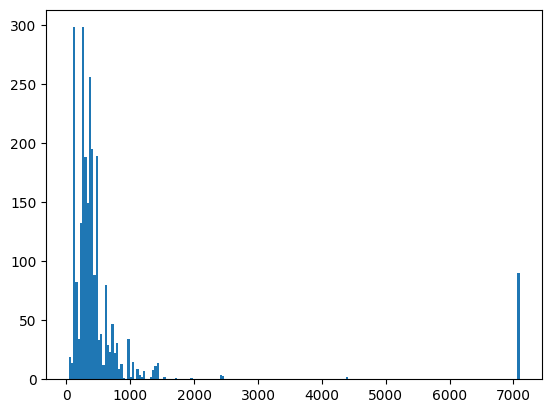

In [6]:
plt.figure()
print(df.len_sequence.mean(), df.len_sequence.std())
plt.hist(df.len_sequence, bins=200)
plt.show()

One of the purpose of this challenge is to work with small sequences. In this notebook, we only work with sequences no longer than 1000 aminoacids.

In [7]:
df = df[df['len_sequence'] <= 1000].reset_index(drop=True)

In [8]:
prot_model.to('cuda')
smiles_model.to('cuda')
esm_model.to('cuda')
print(prot_model.device)

cuda:0


In the next function we create the embeddings of the protein sequence and the ligand. The ligand is given in SMILES notation. For that purpose, we create embeddings using some nice transformer models available in Hugging Face. The models were uploaded in the very beginning of this notebook.

In [10]:
def get_embeddings(model, tokenizer, df, batch_size=128):
    # Ensure model is on CUDA
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Pre-allocate memory for embeddings
    total_samples = df.shape[0]
    embedding_size = model.config.hidden_size  # Get embedding size from model config
    embeddings = np.empty((total_samples, embedding_size), dtype=np.float32)
    
    # Process in batches
    for batch_start in tqdm(range(0, total_samples, batch_size), desc="Processing batches"):
        batch_end = min(batch_start + batch_size, total_samples)
        batch_texts = [' '.join([j for j in i]) for i in df[batch_start:batch_end].values]
        
        # Tokenize and move to CUDA
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Forward pass on CUDA
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Get mean embeddings and move to CPU
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings[batch_start:batch_end] = batch_embeddings
    
    return embeddings

We run the function to get the mentioned embeddings.

In [11]:
print('generating esm embeddings')
esm_emb = get_embeddings(model = esm_model, tokenizer = esm_tokenizer, df = df.iloc[:,1], batch_size=24)
print('generating prot embeddings')
prot_emb = get_embeddings(model = prot_model, tokenizer = prot_tokenizer, df = df.iloc[:,1], batch_size=24)
print('generating smiles embeddings')
smiles_emb = get_embeddings(model = smiles_model, tokenizer = smiles_tokenizer, df = df.iloc[:,0], batch_size=24)

generating esm embeddings


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Processing batches: 100%|██████████████████████████████████████████████████████████████| 97/97 [00:45<00:00,  2.14it/s]


generating prot embeddings


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Processing batches: 100%|██████████████████████████████████████████████████████████████| 97/97 [03:20<00:00,  2.06s/it]


generating smiles embeddings


Processing batches: 100%|██████████████████████████████████████████████████████████████| 97/97 [00:02<00:00, 39.03it/s]


To get a idea of the outreach of the current embeddings, we play with with a linear regression. There are no doubts that the performance will significantly improve with a larger dataset set or a non-linear models based on deep NN.

In [12]:
import sklearn.linear_model

In [168]:
idxtest = np.random.choice(np.arange(df.shape[0]), int(0.2*df.shape[0]), replace=False)
idxtraval = np.setdiff1d(np.arange(df.shape[0]), idxtest)

xtest = np.concatenate((prot_emb[idxtest], smiles_emb[idxtest]), axis=-1)
xtraval = np.concatenate((prot_emb[idxtraval], smiles_emb[idxtraval]), axis=-1)

ytest = df.iloc[idxtest,2].values
ytraval = df.iloc[idxtraval,2].values

totake = np.argwhere(np.isnan(ytraval) == False)[:,0]
testnotnan = np.argwhere(np.isnan(ytest) == False)[:,0]

In [169]:
lr = sklearn.linear_model.Lasso(alpha=1e-3, max_iter=3000, random_state=0)
lr.fit(xtraval[totake], ytraval[totake])

ptraval = lr.predict(xtraval)
ptest = lr.predict(xtest)

C:\Users\igofo\anaconda3\envs\hf\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e+01, tolerance: 5.902e-01
  model = cd_fast.enet_coordinate_descent(


RMSE in test set:1.0674700001552297
MPAE in test set:14.485031159016508
R^2:0.6588703520076338


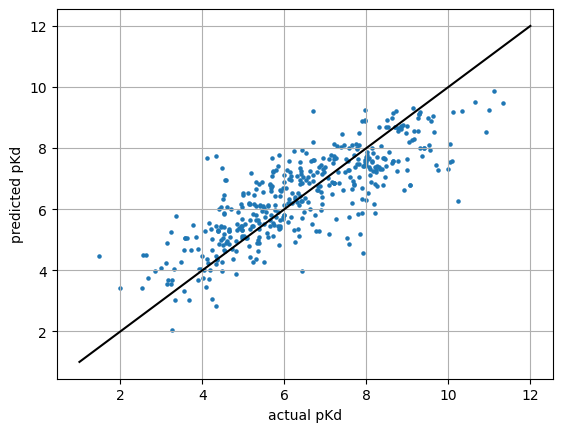

In [170]:
plt.figure()

print(f"RMSE in test set:{((ytest[testnotnan]-ptest[testnotnan])**2).mean()**0.5}")
print(f"MPAE in test set:{(100*abs(ytest[testnotnan]-ptest[testnotnan])/ytest[testnotnan]).mean()}")
print(f"R^2:{lr.score(xtest[testnotnan], ytest[testnotnan])}")

plt.scatter(ytest, ptest, s=5)
plt.plot(np.arange(np.floor(ytest[testnotnan].min()),
                   np.ceil(ytest[testnotnan].max())+1),
         np.arange(np.floor(ytest[testnotnan].min()),
                   np.ceil(ytest[testnotnan].max())+1),color='black')
plt.grid()
plt.xlabel('actual pKd')
plt.ylabel('predicted pKd')
plt.show()

This naive linear model sketches a linear trend between the predicted pKd and the actual ones. This is a good start. Please, consider that in this linear model I implemented Lasso regression ($\alpha$=1e-3), and that the used feature are the embeddings from the Ligand SMILE and the protein sequence.

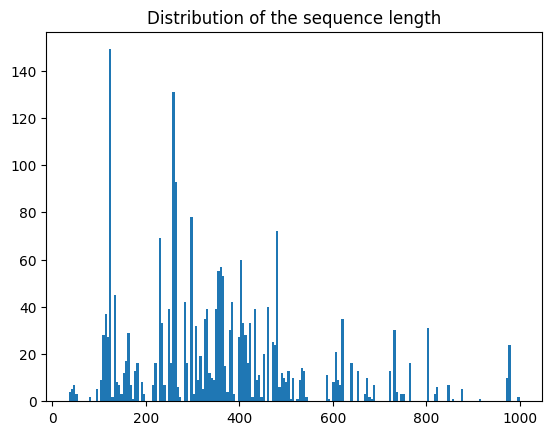

In [172]:
plt.figure()
plt.title('Distribution of the sequence length')
plt.hist(df.iloc[:,-1].values, bins=200)
plt.show()

In [184]:
print(f"Number of unique ligands in the dataset:{len(df['Ligand SMILES'].unique())}")
print(f"Number of unique sequences in the dataset:{len(df.iloc[:,2].unique())}")

Number of unique ligands in the dataset:1231
Number of unique sequences in the dataset:1085
